In [ ]:
#| default_exp io

# Input / Output

AlphaPept can read input from different files. The most important files are those that contain raw MS data. Currently, AlphaPept supports the following raw input formats:

* `.raw` files for `Thermo` raw data.
* `.d` folders for `Bruker` raw data.
* `.mzML` for generic input.

After reading these input files, AlphaPept uses several preprocessing functions to prepare it for subsequent analysis. Functions include, for instance:

* Centroiding of profile data to centroided data.
* Trimming spectra to retain only the `n` most intense peaks.

Finally, AlphaPept exports raw data as a `.ms_data.hdf` file. All subsequent results can be added to this file to ensure ease of use/access, full transparency, and reproducibility using a single well-structured file for the whole analysis instead of using randomly scattered files that all relate to a single dataset.

## Reading raw input

Input can be read from three different files formats:

* `.raw` files describing `Thermo` raw data.
* `.d` folders describing `Bruker` raw data.
* `.mzML` files describing generic input.

All reading functions return a `query_data` dictionary similar to the following structure:

```
query_data = {
    "scan_list_ms1":   np.array(...)
    "rt_list_ms1":     np.array(...)
    "mass_list_ms1":   np.array(...)
    "int_list_ms1":    np.array(...)
    "ms_list_ms1":     np.array(...)
    "scan_list_ms2":   np.array(...)
    "rt_list_ms2":     np.array(...)
    "mass_list_ms2":   mass_list_ms2
    "int_list_ms2":    int_list_ms2
    "ms_list_ms2":     np.array(...)
    "prec_mass_list2": np.array(...)
    "mono_mzs2":       np.array(...)
    "charge2":         np.array(...)
}
```

### Thermo

To read Thermo files, AlphaPept uses the `pyrawfilereader` package, a Python implementation of the commonly used `rawfilereader` tool. By using the custom python version, Thermo files can be read without having to install `MSFileReader`.

The user can pass an additional flag `use_profile_ms1`. This will then use the profile data which is not centroided already an peform centroiding. Note that this will lead to slightly different intensities, as the centroided data uses the apex and the centroid algorithm the summed intensity.

In [ ]:
#| export
def load_thermo_raw(
    raw_file_name: str,
    n_most_abundant: int,
    use_profile_ms1: bool = False,
    callback: callable = None,
) -> tuple:
    """Load raw thermo data as a dictionary.

    Args:
        raw_file_name (str): The name of a Thermo .raw file.
        n_most_abundant (int): The maximum number of peaks to retain per MS2 spectrum.
        use_profile_ms1 (bool): Use profile data or centroid it beforehand. Defaults to False.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.

    Returns:
        tuple: A dictionary with all the raw data and a string with the acquisition_date_time

    """
    from alphapept.pyrawfilereader import RawFileReader
    rawfile = RawFileReader(raw_file_name)

    spec_indices = range(rawfile.FirstSpectrumNumber, rawfile.LastSpectrumNumber + 1)

    scan_list = []
    rt_list = []
    mass_list = []
    int_list = []
    ms_list = []
    prec_mzs_list = []
    mono_mzs_list = []
    charge_list = []

    for idx, i in enumerate(spec_indices):
        try:
            ms_order = rawfile.GetMSOrderForScanNum(i)
            rt = rawfile.RTFromScanNum(i)

            if ms_order == 2:
                prec_mz = rawfile.GetPrecursorMassForScanNum(i, 0)

                mono_mz, charge = rawfile.GetMS2MonoMzAndChargeFromScanNum(i)
            else:
                prec_mz, mono_mz, charge = 0,0,0

            if use_profile_ms1:
                if ms_order == 2:
                    masses, intensity = rawfile.GetCentroidMassListFromScanNum(i)
                    masses, intensity = get_most_abundant(masses, intensity, n_most_abundant)
                else:
                    masses, intensity = rawfile.GetProfileMassListFromScanNum(i)
                    masses, intensity = centroid_data(masses, intensity)

            else:
                masses, intensity = rawfile.GetCentroidMassListFromScanNum(i)
                if ms_order == 2:
                    masses, intensity = get_most_abundant(masses, intensity, n_most_abundant)

            scan_list.append(i)
            rt_list.append(rt)
            mass_list.append(np.array(masses))
            int_list.append(np.array(intensity, dtype=np.int64))
            ms_list.append(ms_order)
            prec_mzs_list.append(prec_mz)
            mono_mzs_list.append(mono_mz)
            charge_list.append(charge)
        except KeyboardInterrupt as e:
            raise e
        except SystemExit as e:
            raise e
        except Exception as e:
            logging.info(f"Bad scan={i} in raw file '{raw_file_name}': {e}")

        if callback:
            callback((idx+1)/len(spec_indices))

    scan_list_ms1 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    rt_list_ms1 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    mass_list_ms1 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    int_list_ms1 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    ms_list_ms1 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 1]

    scan_list_ms2 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    rt_list_ms2 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mass_list_ms2 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    int_list_ms2 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    ms_list_ms2 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mono_mzs2 = [mono_mzs_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    charge2 = [charge_list[i] for i, _ in enumerate(ms_list) if _ == 2]

    prec_mass_list2 = [
        calculate_mass(mono_mzs_list[i], charge_list[i])
        for i, _ in enumerate(ms_list)
        if _ == 2
    ]

    check_sanity(mass_list)

    query_data = {}

    query_data["scan_list_ms1"] = np.array(scan_list_ms1)
    query_data["rt_list_ms1"] = np.array(rt_list_ms1)
    query_data["mass_list_ms1"] = np.array(mass_list_ms1, dtype=object)
    query_data["int_list_ms1"] = np.array(int_list_ms1, dtype=object)
    query_data["ms_list_ms1"] = np.array(ms_list_ms1)

    query_data["scan_list_ms2"] = np.array(scan_list_ms2)
    query_data["rt_list_ms2"] = np.array(rt_list_ms2)
    query_data["mass_list_ms2"] = mass_list_ms2
    query_data["int_list_ms2"] = int_list_ms2
    query_data["ms_list_ms2"] = np.array(ms_list_ms2)
    query_data["prec_mass_list2"] = np.array(prec_mass_list2)
    query_data["mono_mzs2"] = np.array(mono_mzs2)
#     TODO: Refactor charge2 to be consistent: charge_ms2
    query_data["charge2"] = np.array(charge2)

    acquisition_date_time = rawfile.GetCreationDate()

    rawfile.Close()

    return query_data, acquisition_date_time

### Bruker

To access Bruker files, AlphaPept relies on the external `timsdata` library from Bruker (available in the `alphatims\ext` folder, licenses are applicable). Unfortunately, these libraries are only available on Windows and Linux. As a result, the reading of raw data is not available on macOS. However, once raw data is converted to `.ms_data.hdf` output, other workflow steps (besides feature feating) are possible without problems on macOS.

In [ ]:
#| export
def load_bruker_raw(
    d_folder_name: str,
    n_most_abundant: int,
    callback: callable = None,
    **kwargs
) -> tuple:
    """Load raw Bruker data as a dictionary.

    Args:
        d_folder_name (str): The name of a Bruker .d folder.
        n_most_abundant (int): The maximum number of peaks to retain per MS2 spectrum.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.

    Returns:
        tuple: A dictionary with all the raw data and a string with the acquisition_date_time

    """
    import sqlalchemy as db
    import pandas as pd
    from alphapept.constants import mass_dict
    from alphapept.ext.bruker import timsdata
    from alphapept.io import list_to_numpy_f32, get_most_abundant

    tdf = os.path.join(d_folder_name, 'analysis.tdf')
    engine = db.create_engine('sqlite:///{}'.format(tdf))
    prec_data = pd.read_sql_table('Precursors', engine)
    frame_data = pd.read_sql_table('Frames', engine)
    frame_data = frame_data.set_index('Id')

    global_metadata = pd.read_sql_table('GlobalMetadata', engine)
    global_metadata = global_metadata.set_index('Key').to_dict()['Value']
    acquisition_date_time = global_metadata['AcquisitionDateTime']

    tdf = timsdata.TimsData(d_folder_name)

    M_PROTON = mass_dict['Proton']

    prec_data['Mass'] = prec_data['MonoisotopicMz'].values * prec_data['Charge'].values - prec_data['Charge'].values*M_PROTON

    mass_list_ms2 = []
    int_list_ms2 = []
    scan_list_ms2 = []

    prec_data = prec_data.sort_values(by='Mass', ascending=True)

    precursor_ids = prec_data['Id'].tolist()

    for idx, key in enumerate(precursor_ids):

        ms2_data = tdf.readPasefMsMs([key])
        masses, intensity = ms2_data[key]
        masses, intensity = get_most_abundant(np.array(masses), np.array(intensity), n_most_abundant)
        mass_list_ms2.append(masses)
        int_list_ms2.append(intensity)
        scan_list_ms2.append(key)

        if callback:
            callback((idx+1)/len(precursor_ids))

    check_sanity(mass_list_ms2)

    query_data = {}
    query_data['prec_mass_list2'] = prec_data['Mass'].values
    query_data['prec_id2'] = prec_data['Id'].values
    query_data['mono_mzs2'] = prec_data['MonoisotopicMz'].values
    query_data['rt_list_ms2'] = frame_data.loc[prec_data['Parent'].values]['Time'].values / 60 #convert to minutes
    query_data['scan_list_ms2'] = prec_data['Parent'].values
    query_data['charge2'] = prec_data['Charge'].values
    query_data['mobility2'] = tdf.scanNumToOneOverK0(1, prec_data['ScanNumber'].to_list()) #check if its okay to always use first frame
    query_data["mass_list_ms2"] = mass_list_ms2
    query_data["int_list_ms2"] = int_list_ms2

    return query_data, acquisition_date_time

For `ccs` (i.e., ion mobility) values, we need additional functions from the Bruker library. As the live feature-finder might not be able to determine some charge values, it is intended to perform this calculation at a later stage once we have charge values from the post-processing feature finder.

In [ ]:
#| export
import alphapept
import numpy as np

def one_over_k0_to_CCS(
    one_over_k0s: np.ndarray,
    charges: np.ndarray,
    mzs: np.ndarray,
) -> np.ndarray:
    """Retrieve collisional cross section (CCS) values from (mobility, charge, mz) arrays.

    Args:
        one_over_k0s (np.ndarray): The ion mobilities (1D-np.float).
        charges (np.ndarray): The charges (1D-np.int).
        mzs (np.ndarray): The mz values (1D-np.float).

    Returns:
        np.ndarray: The CCS values.

    """
    from alphapept.ext.bruker import timsdata

    ccs = np.empty(len(one_over_k0s))
    ccs[:] = np.nan

    for idx, (one_over, charge, mz) in enumerate(zip(one_over_k0s, charges, mzs)):
        try:
            ccs[idx] = timsdata.oneOverK0ToCCSforMz(one_over, int(charge), mz)
        except ValueError:
            pass
    return ccs

Due to availbility of Bruker libraries, this can only be tested on Windows and Linux.

In [ ]:
#| hide
def test_one_over_k0_to_CCS():
    one_over_k0_to_CCS([1], [1], [1])

# NOTE, test was not enable for a long time and might be outdated by now
# import sys
# if sys.platform[:6] != "darwin":
#     test_one_over_k0_to_CCS()

### Generic `.mzML` files

To access `.mzML` files, we rely on the `pyteomics` package. For using an mzml format for performing a search, Peak Picking (data centroiding) should be applied to all MS levels of the data.

In [ ]:
#| export
def check_sanity(mass_list: np.ndarray) -> None:
    """Sanity check for mass list to make sure the masses are sorted.

    Args:
        mass_list (np.ndarray): The mz values (1D-np.float).

    Raises:
        ValueError: When the mz values are not sorted.

    """
    if not all(
        mass_list[0][i] <= mass_list[0][i + 1] for i in range(len(mass_list[0]) - 1)
    ):
        raise ValueError("Masses are not sorted.")


def extract_mzml_info(input_dict: dict) -> tuple:
    """Extract basic MS coordinate arrays from a dictionary.

    Args:
        input_dict (dict): A dictionary obtained by iterating over a Pyteomics mzml.read function.

    Returns:
        tuple: The rt, masses, intensities, ms_order, prec_mass, mono_mz, charge arrays retrieved from the input_dict.
            If the `ms level` in the input dict does not equal 2, the charge, mono_mz and prec_mass will be equal to 0.

    """
    from alphapept.chem import calculate_mass
    rt = float(input_dict.get('scanList').get('scan')[0].get('scan start time'))  # rt_list_ms1/2
    masses = input_dict.get('m/z array')
    intensities = input_dict.get('intensity array').astype(int)
    ms_order = input_dict.get('ms level')
    prec_mass = mono_mz = charge = 0
    if ms_order == 2:
        try:
            charge = int(input_dict.get('precursorList').get('precursor')[0].get('selectedIonList').get('selectedIon')[0].get(
                'charge state'))
        except TypeError:
            charge = 0
        mono_mz = input_dict.get('precursorList').get('precursor')[0].get('selectedIonList').get('selectedIon')[0].get(
                'selected ion m/z')
        prec_mass = calculate_mass(mono_mz, charge)
    return rt, masses, intensities, ms_order, prec_mass, mono_mz, charge


def load_mzml_data(
    filename: str,
    n_most_abundant: int,
    callback: callable = None,
    **kwargs
) -> tuple:
    """Load data from an mzml file as a dictionary.

    Args:
        filename (str): The name of a .mzml file.
        n_most_abundant (int): The maximum number of peaks to retain per MS2 spectrum.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.

    Returns:
        tuple: A dictionary with all the raw data, a string with the acquisition_date_time and a string with the vendor.

    """
    from pyteomics import mzml
    import os
    import re
    import logging
    import datetime
    import pathlib
    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    try:
        reader = mzml.read(filename, use_index=True)
        spec_indices = np.array(range(1, len(reader) + 1))
    except OSError:
        logging.info('Could not open the file. Please, specify the correct path to the file.')
        sys.exit(1)

    scan_list = []
    rt_list = []
    mass_list = []
    int_list = []
    ms_list = []
    prec_mzs_list = []
    mono_mzs_list = []
    charge_list = []
    
    vendor = "Unknown"
    
    for idx, i in enumerate(spec_indices):
        try:
            spec = next(reader)

            if idx == 0:
                ext = re.findall(r"File:\".+\.(\w+)\"", spec['spectrum title'])[0]
                if ext.lower() == 'raw':
                    vendor = "Thermo"

            scan_list.append(i)
            rt, masses, intensities, ms_order, prec_mass, mono_mz, charge = extract_mzml_info(spec)
            
            sortindex = np.argsort(masses)
            
            masses = masses[sortindex]
            intensities = intensities[sortindex]
            
            if ms_order == 2:
                masses, intensities = get_most_abundant(masses, intensities, n_most_abundant)
            rt_list.append(rt)
            
            #Remove zero intensities
            to_keep = intensities>0
            masses = masses[to_keep]
            intensities = intensities[to_keep]
            
            mass_list.append(masses)
            int_list.append(intensities)
            ms_list.append(ms_order)
            prec_mzs_list.append(prec_mass)
            mono_mzs_list.append(mono_mz)
            charge_list.append(charge)
            
        except KeyboardInterrupt as e:
            raise e
        except SystemExit as e:
            raise e
        except Exception as e:
            logging.info(f"Bad scan={i} in mzML file '{filename}' {e}")

        if callback:
            callback((idx+1)/len(spec_indices))

    check_sanity(mass_list)

    scan_list_ms1 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    rt_list_ms1 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    mass_list_ms1 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    int_list_ms1 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 1]
    ms_list_ms1 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 1]

    scan_list_ms2 = [scan_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    rt_list_ms2 = [rt_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mass_list_ms2 = [mass_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    int_list_ms2 = [int_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    ms_list_ms2 = [ms_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    prec_mass_list2 = [prec_mzs_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    mono_mzs2 = [mono_mzs_list[i] for i, _ in enumerate(ms_list) if _ == 2]
    charge_ms2 = [charge_list[i] for i, _ in enumerate(ms_list) if _ == 2]

    prec_mass_list2 = [
        calculate_mass(mono_mzs_list[i], charge_list[i])
        for i, _ in enumerate(ms_list)
        if _ == 2
    ]

    query_data = {}

    query_data["scan_list_ms1"] = np.array(scan_list_ms1)
    query_data["rt_list_ms1"] = np.array(rt_list_ms1)
    query_data["mass_list_ms1"] = np.array(mass_list_ms1)
    query_data["int_list_ms1"] = np.array(int_list_ms1)
    query_data["ms_list_ms1"] = np.array(ms_list_ms1)

    query_data["scan_list_ms2"] = np.array(scan_list_ms2)
    query_data["rt_list_ms2"] = np.array(rt_list_ms2)
    query_data["mass_list_ms2"] = mass_list_ms2
    query_data["int_list_ms2"] = int_list_ms2
    query_data["ms_list_ms2"] = np.array(ms_list_ms2)
    query_data["prec_mass_list2"] = np.array(prec_mass_list2)
    query_data["mono_mzs2"] = np.array(mono_mzs2)
    query_data["charge2"] = np.array(charge_ms2)

    fname = pathlib.Path(filename)
    acquisition_date_time = datetime.datetime.fromtimestamp(fname.stat().st_mtime).strftime('%Y-%m-%dT%H:%M:%S')

    return query_data, acquisition_date_time, vendor

## Reading other files

Benchmarking proteomics software against each other is not straightforward as various naming conventions exist and different algorithms are implemented. In this section, we define some helper functions that allow us to read results from other tools and facilitate the comparison of different tools against AlphaPept.

### Reading MaxQuant .xml settings file

One of the most commonly used tools to analyze MS data is MaxQuant. AlphaPept reads MaxQuant .xml files as follows:

In [ ]:
#| export
import xml.etree.ElementTree as ET

def __extract_nested(child):
    """
    Helper function to extract nested entries
    """
    if len(child) > 0:
        temp_dict = {}
        for xx in child:
            temp_dict[xx.tag] = __extract_nested(xx)
        return temp_dict
    else:
        if child.text == 'True':
            info = True
        elif child.text == 'False':
            info = False
        else:
            info = child.text
        return info

def extract_mq_settings(path: str) -> dict:
    """Function to return MaxQuant values as a dictionary for a given xml file.

    Args:
        path (str): File name of an xml file.

    Returns:
        dict: A dictionary with MaxQuant info.

    Raises:
        ValueError: When path is not a valid xml file.

    """
    if not path.endswith('.xml'):
        raise ValueError("Path {} is not a valid xml file.".format(path))

    tree = ET.parse(path)
    root = tree.getroot()

    mq_dict = {}

    for child in root:

        mq_dict[child.tag] = __extract_nested(child)

    return mq_dict

In [ ]:
mq_dict = extract_mq_settings('../testfiles/test_mqpar.xml')
mq_dict['fastaFiles']

{'FastaFileInfo': {'fastaFilePath': 'testfile.fasta',
  'identifierParseRule': '>([^\\s]*)',
  'descriptionParseRule': '>(.*)',
  'taxonomyParseRule': None,
  'variationParseRule': None,
  'modificationParseRule': None,
  'taxonomyId': None}}

AlphaPept incorporates PTMs directly in amino acid sequences with lower case identifiers. Parsing MaxQuant sequences with PTMs is done with:

In [ ]:
#| export
def parse_mq_seq(peptide: str) -> str:
    """Replaces maxquant convention to alphapept convention.

    ToDo: include more sequences

    Args:
        peptide (str): A peptide sequence from MaxQuant.

    Returns:
        str: A parsed peptide sequence compatible with AlphaPept.

    """
    peptide = peptide[1:-1] #Remove _

    peptide = peptide.replace('(Acetyl (Protein N-term))','a')
    peptide = peptide.replace('M(Oxidation (M))','oxM')
    peptide = peptide.replace('C','cC') #This is fixed and not indicated in MaxQuant

    return peptide

A quick test shows the results are correct:

In [ ]:
parse_mq_seq('_AFQPFFVELTM(Oxidation (M))PYSVIR_')

'AFQPFFVELToxMPYSVIR'

## Preprocessing data

Raw data needs to be preprocessed to simplify it for AlphaPept analysis. Currently, this requires:

* Profiling of the data
* Trimming of spectra to retain only the 'n'-most intense peaks

### Centroiding profile data

Importing raw data frequently results in profile data. When having profile data, Alphapept first needs to perform centroiding to use this data properly. For this, it needs to search local maxima ("peaks") of the intensity as a function of m/z. For this AlphaPept uses the function `get_peaks`. A peak is described by three points, the `start` of the peak, the `center`, and the `end`. The function accepts an intensity array and calculates the delta (gradient) between consecutive data points to determine the start, center, and end.

In [ ]:
#| export
from numba import njit
import numpy as np

@njit
def get_peaks(int_array: np.ndarray) -> list:
    """Detects peaks in an array.

    Args:
        int_array (np.ndarray): An array with intensity values.

    Returns:
        list: A regular Python list with all peaks.
            A peak is a triplet of the form (start, center, end)

    """
    peaklist = []
    gradient = np.diff(int_array)
    start, center, end = -1, -1, -1

    for i in range(len(gradient)):

        grad = gradient[i]

        if (end == -1) & (center == -1):  # No end and no center yet
            if grad <= 0:  # If decreasing, move start point
                start = i
            else:  # If increasing set as center point
                center = i

        if (end == -1) & (
            center != -1
        ):  # If we have a centerpoint and it is still increasing set as new center
            if grad >= 0:
                center = i
            else:  # If it is decreasing set as endpoint
                end = i

        if end != -1:  # If we have and endpoint and it is going down
            if grad < 0:
                end = i  # Set new Endpoint
            else:  # if it stays the same or goes up set a new peak
                peaklist.append((start + 1, center + 1, end + 1))
                start, center, end = end, -1, -1  # Reset start, center, end

    if end != -1:
        peaklist.append((start + 1, center + 1, end + 1))

    return peaklist

A quick test to illustrate the function:

In [ ]:
int_array = np.array([0,0,0,1,2,3,3,2,1,0,0,1,2,3,2,1,0])
get_peaks(int_array)

[(2, 6, 9), (9, 13, 16)]

In [ ]:
#| hide
def test_get_peaks():
    int_array = np.array([0,0,0,1,2,3,3,2,1,0,0,1,2,3,2,1,0])
    assert get_peaks(int_array) == [(2, 6, 9), (9, 13, 16)]
    
test_get_peaks()

To determine the center of the peak, we distinguish based on the number of raw data points that are contained in the peak:

* One data point: m/z value of this point is taken as the center
* Two datapoints: Average of the two m/z values, weighted by the intensities
* Three or more data points: Gaussian estimation of the center position.

For the Gaussian estimation, only the three central points are used to fit a Gaussian Peak shape. The Gaussian is then approximated with the logarithm. 

The gaussian estimator is defined in `gaussian_estimator` and is used by the wrapper `get_centroid`.

In [ ]:
#| export
from numba import njit

@njit
def get_centroid(
    peak: tuple,
    mz_array: np.ndarray,
    int_array: np.ndarray
) -> tuple:
    """Wrapper to estimate centroid center positions.

    Args:
        peak (tuple): A triplet of the form (start, center, end)
        mz_array (np.ndarray): An array with mz values.
        int_array (np.ndarray): An array with intensity values.

    Returns:
        tuple: A tuple of the form (center, intensity)
    """
    start, center, end = peak
    mz_int = np.sum(int_array[start + 1 : end])

    peak_size = end - start - 1

    if peak_size == 1:
        mz_cent = mz_array[center]
    elif peak_size == 2:
        mz_cent = (
            mz_array[start + 1] * int_array[start + 1]
            + mz_array[end - 1] * int_array[end - 1]
        ) / (int_array[start + 1] + int_array[end - 1])
    else:
        mz_cent = gaussian_estimator(peak, mz_array, int_array)

    return mz_cent, mz_int

@njit
def gaussian_estimator(
    peak: tuple,
    mz_array: np.ndarray,
    int_array: np.ndarray
) -> float:
    """Three-point gaussian estimator.

    Args:
        peak (tuple): A triplet of the form (start, center, end)
        mz_array (np.ndarray): An array with mz values.
        int_array (np.ndarray): An array with intensity values.

    Returns:
        float: The gaussian estimate of the center.
    """
    start, center, end = peak

    m1, m2, m3 = mz_array[center - 1], mz_array[center], mz_array[center + 1]
    i1, i2, i3 = int_array[center - 1], int_array[center], int_array[center + 1]

    if i1 == 0:  # Case of sharp flanks
        m = (m2 * i2 + m3 * i3) / (i2 + i3)
    elif i3 == 0:
        m = (m1 * i1 + m2 * i2) / (i1 + i2)
    else:
        l1, l2, l3 = np.log(i1), np.log(i2), np.log(i3)
        m = (
            ((l2 - l3) * (m1 ** 2) + (l3 - l1) * (m2 ** 2) + (l1 - l2) * (m3 ** 2))
            / ((l2 - l3) * (m1) + (l3 - l1) * (m2) + (l1 - l2) * (m3))
            * 1
            / 2
        )

    return m

The function performs as expected:

In [ ]:
int_array = np.array([0,0,0,1,2,3,3,2,1,0,0,1,2,3,2,1,0])
mz_array = np.array([0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
peak = (2, 6, 9)

print(gaussian_estimator(peak, mz_array, int_array))
print(get_centroid(peak, mz_array, int_array))

4.499999999999999
(4.499999999999999, 12)


In [ ]:
#| hide
def test_get_centroid():
    
    int_array = np.array([0,0,0,1,2,3,3,2,1,0,0,1,2,3,2,1,0])
    mz_array = np.array([0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    
    peak = (2, 6, 9)
    
    mz, intsum = get_centroid(peak, mz_array, int_array)
    
    assert np.allclose(mz, 4.499999999999999)
    assert np.allclose(intsum, 12)
    
    def gaussian(x, mu, sigma):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    test_values = np.arange(0, 200)
    gauss_trace = np.zeros(len(test_values))

    centers = [30, 60, 120]
    sigmas = [1, 2, 3]

    for center, sigma in zip(centers, sigmas):
        gauss_trace += np.round(gaussian(test_values, center, sigma), 3)

    peaks = get_peaks(gauss_trace)
    centers_found = [_[1] for _ in peaks]

    assert set(centers) == set(centers_found)

    for i, peak in enumerate(peaks):
        center_est, a = get_centroid(peak, test_values, gauss_trace)
        sigma_est = (a * 0.3989) / 1

        assert np.round(center_est, 2) == centers[i]
        assert np.round(sigma_est, 2) == sigmas[i]
        
test_get_centroid()

The detected centroid can also easily be visualized:

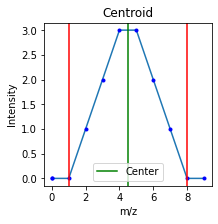

In [ ]:
import matplotlib.pyplot as plt


def plot_centroid(peak, mz_array, int_array):

    plt.figure(figsize=(3, 3))

    start, center, end = peak

    centroid = get_centroid((start, center, end), mz_array, int_array)

    plt.plot(mz_array[start - 2 : end + 2], int_array[start - 2 : end + 2])
    plt.plot(mz_array[start - 2 : end + 2], int_array[start - 2 : end + 2], "b.")
    plt.axvline(mz_array[start], color="r")
    plt.axvline(mz_array[end], color="r")

    plt.axvline(centroid[0], color="g", label='Center')
    plt.title("Centroid")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.legend()

    plt.show()
    
int_array = np.array([0,0,0,1,2,3,3,2,1,0,0,1,2,3,2,1,0])
mz_array = np.array([0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

peak = (2, 6, 9)
    
plot_centroid(peak, mz_array, int_array)

In [ ]:
#| export

@njit
def centroid_data(
    mz_array: np.ndarray,
    int_array: np.ndarray
) -> tuple:
    """Estimate centroids and intensities from profile data.

    Args:
        mz_array (np.ndarray): An array with mz values.
        int_array (np.ndarray): An array with intensity values.

    Returns:
        tuple: A tuple of the form (mz_array_centroided, int_array_centroided)
    """
    peaks = get_peaks(int_array)

    mz_array_centroided = np.zeros(len(peaks))
    int_array_centroided = np.zeros(len(peaks))


    for i in range(len(peaks)):
        mz_, int_ = get_centroid(peaks[i], mz_array, int_array)
        mz_array_centroided[i] = mz_
        int_array_centroided[i] = int_

    return mz_array_centroided, int_array_centroided

### Trimming spectra to retain the `n` most intense peaks

`get_most_abundant`: In order to save spectra in a more memory-efficient form, we only keep the n most abundant peaks. This allows us to save data in a fast, accessible matrix format. 

`get_local_intensity`: This calculates the local intensity to get local maxima.

In [ ]:
#| export
from alphapept.chem import calculate_mass
from tqdm import tqdm
import numpy as np
from numba.typed import List
from numba import njit
import gzip
import sys
import os
import logging

@njit
def get_local_intensity(intensity, window=10):
    """
    Calculate the local intensity for a spectrum.

    Args:
        intensity (np.ndarray): An array with intensity values.
        window (int): Window Size
    Returns:
        nop.ndarray: local intensity
    """

    local_intensity = np.zeros(len(intensity))

    for i in range(len(intensity)):
        start = max(0, i-window) 
        end = min(len(intensity), i+window)
        local_intensity[i] = intensity[i]/np.max(intensity[start:end])
        
    return local_intensity

def get_most_abundant(
    mass: np.ndarray,
    intensity: np.ndarray,
    n_max: int,
    window: int = 10,
) -> tuple:
    """Returns the n_max most abundant peaks of a spectrum.

    Args:
        mass (np.ndarray): An array with mz values.
        intensity (np.ndarray): An array with intensity values.
        n_max (int): The maximum number of peaks to retain.
            Setting `n_max` to -1 returns all peaks.
        window (int): Use local maximum in a window

    Returns:
        tuple: the filtered mass and intensity arrays.

    """
    if n_max == -1:
        return mass, intensity
    if len(mass) < n_max:
        return mass, intensity
    else:
        
        if window > 0:
            sortindex = np.argsort(get_local_intensity(intensity, window))[::-1][:n_max]
        else:
            sortindex = np.argsort(intensity)[::-1][:n_max]
        
        sortindex.sort()

    return mass[sortindex], intensity[sortindex]

For saving, we are currently relying on the hdf-container (see below).

While we could, in principle, store the mz and int arrays as a list of variable length, this will come at a performance decrease. We, therefore, create an array of the dimensions of the n most abundant peaks and the number of spectra with the function `list_to_numpy_f32` and fill the unoccupied cells with `-1`. This allows an increase in accessing times at the cost of additional disk space.

In [ ]:
#| export
def list_to_numpy_f32(
    long_list: list
) -> np.ndarray:
    """Function to convert a list to np.float32 array.

    Args:
        long_list (list): A regular Python list with values that can be converted to floats.

    Returns:
        np.ndarray: A np.float32 array.

    """
    np_array = (
        np.zeros(
            [len(max(long_list, key=lambda x: len(x))), len(long_list)],
            dtype=np.float32,
        )
        - 1
    )
    for i, j in enumerate(long_list):
        np_array[0 : len(j), i] = j

    return np_array

## Saving output

As MS hardware has continued to improve over the years, MS data has become more complex. To deal with this complexity, the MS community has already used many different [data formats](https://onlinelibrary.wiley.com/doi/full/10.1002/mas.21522) to store and access data. [HDF](https://www.hdfgroup.org/solutions/hdf5/) containers are one option, but they have not yet gained widespread support.

### HDF containers in general

In general, an HDF container can be viewed as a compressed folder with metadata (i.e., attributes) associated to each single subfolder or file (i.e., data arrays of various types and sizes) within this container. A container might, for instance have contents that look like, e.g.:
```
HDF_Container
    {
        meta_data_1: "Some string",
        meta_data_2: 1234567890,
        ...
    }
    array_1
        {
            meta_data_of_array1_1: "Some other string",
            ...
        },
        100x2 int8
    array_2
        1000x2 float64
    subfolder_1
        {
            meta_data_of_subfolder_1_1: "Really any string of any length",
            ...
        }
        array_1_of_subfolder_1
        subfolder_1_1
        ...
    subfolder_n
    ...
```


A few of the advantages of HDF are, e.g.:

* It has no upper limit with regards to file size
* It can be used on disk without consuming RAM memory
* It is fully portable on different machines and systems
* It is capable of fast IO operations
* It allows data to be structured very transparent while still providing a flexible way to store metadata
* ...

For these reasons, HDF containers have gained popularity in several scientific fields, including (astro)physics and geology. It is, therefore, no surprise that Python has excellent support for HDF containers. The two most used packages are `h5py` and `tables`, where the former has a generic API and the second is frequently used with `pandas` dataframes. An excellent viewer for HDF files is [HDF Compass](https://support.hdfgroup.org/projects/compass/).

### Using HDF containers in AlphaPept

AlphaPept uses the python `h5py` package to store MS data in HDF containers, inspired by the [ion_networks](https://github.com/swillems/ion_networks) repository.

* First, a generic class is defined that will serve as an API for HDF containers. To ensure full transparency, this will include immutable metadata such as `creation time`, `original_file_name` and `version`.
* The constructor of an HDF_File will be passed the `file_name` of an HDF container, an `is_read_only` flag, an `is_overwritable` flag and `is_new_file` flag.
* To compare HDF_Files, several (magic) functions need to be defined.
* Traceability and reproducibility are ensured by storing a `last_updated` and a `check` function to warn users about potential compatibility issues.

In [ ]:
#| export

import h5py
import os
import time
from alphapept.__main__ import VERSION_NO


class HDF_File(object):
    '''
    A generic class to store and retrieve on-disk
    data with an HDF container.
    '''

    @property
    def original_file_name(self):
        return self.read(
            attr_name="original_file_name"
        )  # See below for function definition

    @property
    def file_name(self):
        return self.__file_name

    @property
    def directory(self):
        return os.path.dirname(self.file_name)

    @property
    def creation_time(self):
        return self.read(
            attr_name="creation_time"
        )  # See below for function definition

    @property
    def last_updated(self):
        return self.read(
            attr_name="last_updated"
        )  # See below for function definition

    @property
    def version(self):
        return self.read(
            attr_name="version"
        )  # See below for function definition

    @property
    def is_read_only(self):
        return self.__is_read_only

    @property
    def is_overwritable(self):
        return self.__is_overwritable

    def read(self):
        pass

    def write(self):
        pass

    def __init__(
        self,
        file_name: str,
        is_read_only: bool = True,
        is_new_file: bool = False,
        is_overwritable: bool = False,
    ):
        """Create/open a wrapper object to access HDF data.

        Args:
            file_name (str): The file_name of the HDF file.
            is_read_only (bool): If True, the HDF file cannot be modified. Defaults to True.
            is_new_file (bool): If True, an already existing file will be completely removed. Defaults to False.
            is_overwritable (bool): If True, already existing arrays will be overwritten. If False, only new data can be appended. Defaults to False.

        """
        self.__file_name = os.path.abspath(file_name)
        if is_new_file:
            is_read_only = False
            if not os.path.exists(self.directory):
                os.makedirs(self.directory)
            with h5py.File(self.file_name, "w") as hdf_file:
                current_time = time.asctime()
                hdf_file.attrs["creation_time"] = current_time
                hdf_file.attrs["original_file_name"] = self.__file_name
                hdf_file.attrs["version"] = VERSION_NO
                hdf_file.attrs["last_updated"] = current_time
        else:
            with h5py.File(self.file_name, "r") as hdf_file:
                self.check()
        if is_overwritable:
            is_read_only = False
        self.__is_read_only = is_read_only
        self.__is_overwritable = is_overwritable

    def __eq__(self, other):
        return self.file_name == other.file_name

    def __hash__(self):
        return hash(self.file_name)

    def __str__(self):
        return f"<HDF_File {self.file_name}>"

    def __repr__(self):
        return str(self)

    def check(
        self,
        version: bool = True,
        file_name: bool = True,
    ) -> list:
        """Check if the `version` or `file_name` of this HDF_File have changed.

        Args:
            version (bool): If False, do not check the version. Defaults to True.
            file_name (bool): If False, do not check the file_name. Defaults to True.

        Returns:
            list: A list of warning messages stating any issues.

        """
        warning_messages = []
        if version:
            current_version = VERSION_NO
            creation_version = self.version
            if creation_version != current_version:
                warning_messages.append(
                    f"{self} was created with version "
                    f"{creation_version} instead of {current_version}."
                )
        if file_name:
            if self.file_name != self.original_file_name:
                warning_messages.append(
                    f"The file name of {self} has been changed from"
                    f"{self.original_file_name} to {self.file_name}."
                )
        return warning_messages

Contents of HDF containers come in three variants:

1. `Groups`: folders
2. `Datasets`: arrays
3. `Attributes`: metadata associated with individual datasets or groups (with the root folder also considered as a normal group)

These contents can be accessed with `read` and `write` functions.

In [ ]:
#| export

import pandas as pd
from fastcore.foundation import patch


@patch
def read(
    self: HDF_File,
    group_name: str = None,
    dataset_name: str = None,
    attr_name: str = None,
    return_dataset_shape: bool = False,
    return_dataset_dtype: bool = False,
    return_dataset_slice: slice = slice(None),
    swmr: bool = False,
):
    """Read contents of an HDF_File.

    Args:
        group_name (str): The group_name from where to read data.
            If no `group_name` has been provided, read directly from the root group.
            Defaults to None.
        dataset_name (str): The dataset to read.
            If no `dataset_name` has been provided, read directly from the group.
            If the `dataset_name` refers to a group, it is assumed to be
            pd.DataFrame and returned as such.
            Defaults to None.
        attr_name (str): The attribute to read.
            If `attr_name` is not None, read the attribute value instead of the contents of a group or dataset.
            If `attr_name` == "", read all attributes as a dict.
            Defaults to None.
        return_dataset_shape (bool): Do not read complete dataset to minimize RAM and IO usage.
            Defaults to False.
        return_dataset_dtype (bool): Do not read complete dataset to minimize RAM and IO usage.
            Defaults to False.
        return_dataset_slice (slice): Do not read complete dataset to minimize RAM and IO usage.
            Defaults to slice(None).
        swmr (bool): Use swmr mode to read data. Defaults to False.

    Returns:
        type: Depending on what is requested, a dict, value, np.ndarray or pd.dataframe is returned.

    Raises:
        KeyError: When the group_name does not exist.
        KeyError: When the attr_name does not exist in the group or dataset.
        KeyError: When the dataset_name does not exist in the group.
        ValueError: When the requested dataset is not a np.ndarray or pd.dataframe.

    """
    with h5py.File(self.file_name, "r", swmr=swmr) as hdf_file:
        if group_name is None:
            group = hdf_file
            group_name = "/"
        else:
            try:
                group = hdf_file[group_name]
            except KeyError as k:
                raise KeyError(
                    f"Group {group_name} does not exist in {self}. Error {k}"
                )
        if dataset_name is None:
            if attr_name is None:
                return sorted(group)
            elif attr_name != "":
                try:
                    return group.attrs[attr_name]
                except KeyError:
                    raise KeyError(
                        f"Attribute {attr_name} does not exist for "
                        f"group {group_name} of {self}."
                    )
            else:
                return dict(group.attrs)
        else:
            try:
                dataset = group[dataset_name]
            except KeyError:
                raise KeyError(
                    f"Dataset {dataset_name} does not exist for "
                    f"group {group_name} of {self}."
                )
            if attr_name is None:
                if isinstance(dataset, h5py.Dataset):
                    if return_dataset_shape:
                        return dataset.shape
                    elif return_dataset_dtype:
                        return dataset.dtype
                    else:
                        array = dataset[return_dataset_slice]
                        # TODO: This assumes any object array is a string array
                        if array.dtype == object:
                            array = array.astype(str)
                        return array
                elif dataset.attrs["is_pd_dataframe"]:
                    if return_dataset_shape:
                        columns = list(dataset)
                        return (
                            len(dataset[columns[0]]),
                            len(columns)
                        )
                    elif return_dataset_dtype:
                        return [
                            dataset[column].dtype for column in sorted(
                                dataset
                            )
                        ]
                    else:
                        df = pd.DataFrame(
                            {
                                column: dataset[column][
                                    return_dataset_slice
                                ] for column in sorted(dataset)
                            }
                        )
                        # TODO: This assumes any object array is a string array
                        for column in dataset:
                            if df[column].dtype == object:
                                df[column] = df[column].apply(
                                    lambda x: x if isinstance(x, str) else x.decode('UTF-8')
                                )
                        return df
                else:
                    raise ValueError(
                        f"{dataset_name} is not a valid dataset in "
                        f"group {group_name} of {self}."
                    )
            elif attr_name != "":
                try:
                    return dataset.attrs[attr_name]
                except KeyError:
                    raise KeyError(
                        f"Attribute {attr_name} does not exist for "
                        f"dataset {dataset_name} of group "
                        f"{group_name} of {self}."
                    )
            else:
                return dict(dataset.attrs)


@patch
def write(
    self:HDF_File,
    value,
    group_name:str=None,
    dataset_name:str=None,
    attr_name:str=None,
    overwrite:bool=None,
    dataset_compression:str=None,
    swmr:bool=False,
) -> None:
    """Write a `value` to an HDF_File.

    Args:
        value (type): The name of the data to write.
            If the `value` is pd.DataFrame, a `dataset_name` must be provided.
        group_name (str): The group where to write data.
            If no `group_name` is provided, write directly to the root group.
            Defaults to None.
        dataset_name (str): If no `dataset_name` is provided,
            create a new group with `value` as name.
            The dataset where to write data. Defaults to None.
        attr_name (str): The attr where to write data. Defaults to None.
        overwrite (bool): Overwrite pre-existing data and truncate existing groups.
            If the False, ignore the is_overwritable flag of this HDF_File.
            Defaults to None.
        dataset_compression (str): The compression type to use for datasets.
            Defaults to None.
        swmr (bool): Open files in swmr mode. Defaults to False.

    Raises:
        IOError: When the object is read-only.
        KeyError: When the group_name or attr_name does not exist.
        ValueError: When trying to overwrite something while overwiting is disabled.

    """
    if self.is_read_only:
        raise IOError(
            f"Trying to write to {self}, which is read_only."
        )
    if overwrite is None:
        overwrite = self.is_overwritable
    with h5py.File(self.file_name, "a", swmr=swmr) as hdf_file:

        if group_name is None:
            group = hdf_file
            group_name = "/"
        else:
            try:
                group = hdf_file[group_name]
            except KeyError:
                raise KeyError(
                    f"Group {group_name} does not exist in {self}."
                )
        if dataset_name is None:
            if attr_name is None:
                if value in group:
                    if overwrite:
                        del group[value]
                    else:
                        raise ValueError(
                            f"New group {value} already exists in group "
                            f"{group_name} of {self}."
                        )
                group.create_group(value)
            else:
                if (attr_name in group.attrs) and not overwrite:
                    raise ValueError(
                        f"Attribute {attr_name} already exists in group "
                        f"{group_name} of {self}."
                    )
                try:
                    group.attrs[attr_name] = value
                except TypeError:
                    group.attrs[attr_name] = str(value)
        else:
            if attr_name is None:
                if dataset_name in group:
                    if overwrite:
                        del group[dataset_name]
                    else:
                        raise ValueError(
                            f"Dataset {dataset_name} already exists in group "
                            f"{group_name} of {self}."
                        )
                if isinstance(value, pd.core.frame.DataFrame):
                    new_group_name = f"{group_name}/{dataset_name}"
                    self.write(
                        dataset_name,
                        group_name=group_name,
                        overwrite=overwrite,
                    )
                    self.write(
                        True,
                        group_name=new_group_name,
                        attr_name="is_pd_dataframe",
                        overwrite=overwrite,
                    )
                    for column in value.columns:
                        self.write(
                            value[column].values,
                            group_name=new_group_name,
                            dataset_name=column,
                            overwrite=overwrite,
                            dataset_compression=dataset_compression,
                        )
                else:
                    dtype = value.dtype
                    if value.dtype == np.dtype('O'):
                        dtype = h5py.string_dtype()
                    try:
                        hdf_dataset = group.create_dataset(
                            dataset_name,
                            data=value,
                            compression=dataset_compression,
                            dtype=dtype
                        )
                    except TypeError:
                        # TODO
                        # print(f"Cannot save array {value} to HDF, skipping it...")
                        pass
            else:
                try:
                    dataset = group[dataset_name]
                except KeyError:
                    raise KeyError(
                        f"Dataset {dataset_name} does not exist for "
                        f"group {group_name} of {self}."
                    )
                if (attr_name in dataset.attrs) and not overwrite:
                    raise ValueError(
                        f"Attribute {attr_name} already exists in "
                        f"dataset {dataset_name} of group "
                        f"{group_name} of {self}."
                    )
                try:
                    dataset.attrs[attr_name] = value
                except TypeError:
                    dataset.attrs[attr_name] = str(value) # e.g. dicts
        hdf_file.attrs["last_updated"] = time.asctime()

Unit tests for this generic HDF class include:

* Creation and truncation of files with various access.
* Writing and reading data from the container.

In [ ]:
#| hide

import numpy as np
import unittest
import os
import alphapept.io
import pandas as pd


def define_new_test_files(test_folder):
    test_file_names = [
        os.path.abspath(
            os.path.join(test_folder, f"{file_name}.hdf")
        ) for file_name in [
            "test0",
            "test1",
            "test2",
        ]
    ]
    for file_name in test_file_names:
        if os.path.isfile(file_name):
            os.remove(file_name)
    return test_file_names

def test_hdf_file_creation(test_folder):
    test_file_names = define_new_test_files(test_folder)
    try:
        f0 = HDF_File(test_file_names[0])
    except OSError:
        assert True
    else:
        assert False, "Non-existing file should raise an error"
    f0 = HDF_File(test_file_names[0], is_new_file=True)
    assert f0.is_read_only == False, "New files should never be read-only"
    del f0
    try:
        f0 = HDF_File(test_file_names[0])
    except OSError:
        assert False, "Newly created file should exist on disk"
    else:
        assert True
    assert f0.is_read_only == True, "Existing files should be read-only"
    assert f0.file_name == test_file_names[0], "File name should match given file name"
    assert f0.original_file_name == test_file_names[0], "Original file name should match given file name"
    assert f0.version == VERSION_NO, "Versions should match"
    assert str(f0) == f"<HDF_File {test_file_names[0]}>", "File name should match"
    del f0
    os.rename(test_file_names[0], test_file_names[1])
    f1 = HDF_File(test_file_names[1])
    assert f1.original_file_name != test_file_names[1], "Original file name should not match given file name"
    assert f1.directory == os.path.abspath(test_folder), "Directory should match"
    f0 = HDF_File(test_file_names[0], is_new_file=True)
    assert f0 != f1, "Different file names should be different HDF_Files"
    del f0
    f1_copy = HDF_File(test_file_names[1], is_read_only=False)
    assert f1 == f1_copy, "Same file names should be same HDF_Files"
    assert f1_copy.is_read_only == False, "File should not be read-only"


def test_hdf_file_read_and_write(test_folder):
    test_file_names = define_new_test_files(test_folder)
    f0 = HDF_File(test_file_names[0], is_new_file=True)
    try:
        f0.read(group_name="subgroup")
    except KeyError:
        assert True
    else:
        assert False, "subgroup should not exist"
    f0.write("subgroup")
    try:
        f0.read(group_name="subgroup")
    except KeyError:
        assert False, "Subgroup should exist"
    else:
        assert True
    z = np.random.random((100, 4))
    f0.write(z, group_name="subgroup", dataset_name="random")
    f0_copy = HDF_File(test_file_names[0])
    assert f0_copy.read(
        dataset_name="random",
        group_name="subgroup",
        return_dataset_shape=True
    ) == z.shape, "Shape of dataset is not correct"
    assert f0_copy.read(
        dataset_name="random",
        group_name="subgroup",
        return_dataset_dtype=True
    ) == z.dtype, "Type of dataset is not correct"
    assert np.all(
        f0_copy.read(dataset_name="random", group_name="subgroup") == z
    ), "Contents of dataset are not correct"
    try:
        f0.write(z, group_name="subgroup", dataset_name="random")
    except ValueError:
        assert True
    else:
        assert False, "Should not overwrite dataset"
    try:
        f0.write(z, group_name="subgroup", dataset_name="random", overwrite=True)
    except ValueError:
        assert False, "Should be able to overwrite dataset"
    else:
        assert True
    f0.write(
        4,
        dataset_name="random",
        group_name="subgroup",
        attr_name="numeric_attr",
    )
    assert f0.read(
        dataset_name="random",
        group_name="subgroup",
        attr_name="numeric_attr",
    ) == 4, "Attr shoud match"
    f0.write(
        "test",
        dataset_name="random",
        group_name="subgroup",
        attr_name="string_attr",
    )
    assert f0.read(
        dataset_name="random",
        group_name="subgroup",
        attr_name="string_attr",
    ) == "test", "String attr shoud match"
    f0.write(
        list(range(5)),
        dataset_name="random",
        group_name="subgroup",
        attr_name="int_list_attr",
    )
    assert np.all(
        f0.read(
            dataset_name="random",
            group_name="subgroup",
            attr_name="int_list_attr",
        ) == list(range(5))
    ), "Attr shoud match"
    mixed_list =  ["test", "mixed", 2, 4.9]
    try:
        f0.write(
            mixed_list,
            dataset_name="random",
            group_name="subgroup",
            attr_name="int_list_attr",
        )
    except ValueError:
        assert True
    else:
        assert False, "Should not be able to overwrite attr"
    f0.write(
        mixed_list,
        dataset_name="random",
        group_name="subgroup",
        attr_name="int_list_attr",
        overwrite=True
    )
#     assert np.all(
#         f0.read(
#             dataset_name="random",
#             group_name="subgroup",
#             attr_name="int_list_attr",
#         ) == mixed_list
#     ), "Attr of mixed list should match"
    f0.write(
        {"t": 1},
        dataset_name="random",
        group_name="subgroup",
        attr_name="dict_attr",
        overwrite=True
    )
    assert np.all(
        f0.read(
            dataset_name="random",
            group_name="subgroup",
            attr_name="dict_attr",
        ) == str({"t": 1})
    ), "Attr shoud match"
    

def test_hdf_file_data_frames(test_folder):
    test_file_names = define_new_test_files(test_folder)
    f0 = HDF_File(test_file_names[0], is_new_file=True)
    df = pd.DataFrame(
        {
            "col1": np.arange(10, dtype=np.float16) / 2,
            "col2": np.arange(10),
        }
    )
    f0.write(df, dataset_name="df")
    z = f0.read(dataset_name="df")
    assert z.equals(df)
    
test_hdf_file_creation(test_folder="tmp")
test_hdf_file_read_and_write(test_folder="tmp")
test_hdf_file_data_frames(test_folder="tmp")

### The final `.ms_data.hdf` file

Based on the generic HDF_File, a subclass that acts as an MS data container can be implemented. This class should contain all (centroided) fragment ions, all their coordinates, and all the metadata.

In [ ]:
#| export

class MS_Data_File(HDF_File):
    """ A class to store and retrieve on-disk MS data with an HDF container."""
    pass

A single generic function should allow to read raw data and store spectra. Different arguments allow different vendor formats.

In [ ]:
#| export

@patch
def import_raw_DDA_data(
    self:MS_Data_File,
    file_name:str,
    n_most_abundant:int=-1,
    callback:callable=None,
    query_data:dict=None,
    vendor:str=None
) -> None:
    """Load centroided data and save it to this object.

    Args:
        file_name (str): The file name with raw data (Thermo, Bruker or mzml).
        n_most_abundant (int): The maximum number of peaks to retain per MS2 spectrum.\
            Defaults to -1.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.
        query_data (dict):
            A dictionary with raw data.
            If this is not None, data will only be saved and not imported.
            Defaults to None.
        vendor (str): The vendor name, must be Thermo or Bruker if provided.
            Defaults to None.

    """
    base, ext = os.path.splitext(file_name)
    if query_data is None:
        query_data, vendor, acquisition_date_time = _read_DDA_query_data(
            file_name,
            n_most_abundant=n_most_abundant,
            callback=callback
        )
    self._save_DDA_query_data(query_data, vendor, acquisition_date_time)
    
    
def index_ragged_list(ragged_list: list)  -> np.ndarray:
    """Create lookup indices for a list of arrays for concatenation.

    Args:
        value (list): Input list of arrays.

    Returns:
        indices: A numpy array with indices.
    """
    indices = np.zeros(len(ragged_list) + 1, np.int64)
    indices[1:] = [len(i) for i in ragged_list]
    indices = np.cumsum(indices)
    
    return indices

def _read_DDA_query_data(
    file_name:str,
    n_most_abundant:int=-1,
    callback:callable=None
) -> tuple:
    """Read raw data and return as query dictionary.

    Args:
        file_name (str): The file name with raw data (Thermo, Bruker or mzml).
        n_most_abundant (int): The maximum number of peaks to retain per MS2 spectrum.\
            Defaults to -1.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.

    Returns:
        tuple: A tuple with (query_data, vendor, acquisition_date_time).

    Raises:
        NotImplementedError: If the raw data is no Bruker, Thermo or mzml.

    """
    base, ext = os.path.splitext(file_name)
    if ext.lower() == '.raw':
        if os.path.isdir(file_name):
            vendor = "Waters"
            acquisition_date_time = None
            raise NotImplementedError(
                f'File extension {ext} indicates Waters, which is not implemented.'
            )
        else:
            vendor = "Thermo"
            logging.info(f'File {base} has extension {ext} - converting from {vendor}.')
            query_data, acquisition_date_time = load_thermo_raw(
                file_name,
                n_most_abundant,
                callback=callback,
            )
    elif ext.lower() == '.d':
        vendor = "Bruker"
        logging.info(f'File {base} has extension {ext} - converting from {vendor}.')
        query_data, acquisition_date_time = load_bruker_raw(
            file_name,
            n_most_abundant,
            callback=callback,
        )
    elif ext.lower() == '.mzml':
        logging.info(f'File {base} has extension {ext} - converting from {ext[1:]}.')
        query_data, acquisition_date_time, vendor = load_mzml_data(
            file_name,
            n_most_abundant,
            callback=callback,
        )
    else:
        raise NotImplementedError(f'File extension {ext} not understood.')
    logging.info(
        f'File conversion complete. Extracted {len(query_data["prec_mass_list2"]):,} precursors.'
    )
    return query_data, vendor, acquisition_date_time


@patch
def _save_DDA_query_data(
    self:MS_Data_File,
    query_data:dict,
    vendor:str,
    acquisition_date_time:str,
    overwrite:bool=False
) -> None:
    """Save a query dict to this ms_data object.

    Args:
        query_data (dict): A dictionary with data for MS1 and MS2 scans.
        vendor (str): The vendor name, must be Thermo or Bruker if provided.
        acquisition_date_time (str): A string that indicates when the data was acquired.
        overwrite (bool): Overwrite pre-existing data and truncate existing groups.
            If the False, ignore the is_overwritable flag of this HDF_File.
            Defaults to None.

    Raises:
        KeyError: If the query_dict contains keys that do not end with 1 or 2.
            i.e. are not MS1 or MS2 spectra.

    """
#     if vendor == "Bruker":
#         raise NotImplementedError("Unclear what are ms1 and ms2 attributes for bruker")
    if "Raw" not in self.read():
        self.write("Raw")
    self.write(vendor, group_name="Raw", attr_name="vendor")
    self.write(acquisition_date_time, group_name="Raw", attr_name="acquisition_date_time")
    if "MS1_scans" not in self.read(group_name="Raw"):
        self.write("MS1_scans", group_name="Raw")
    if "MS2_scans" not in self.read(group_name="Raw"):
        self.write("MS2_scans", group_name="Raw")
    for key, value in query_data.items():
        if key.endswith("1"):
#             TODO: Weak check for ms2, imporve to _ms1 if consistency in naming is guaranteed
            if key == "mass_list_ms1":
                indices = index_ragged_list(value)
                self.write(
                    indices,
                    dataset_name="indices_ms1",
                    group_name=f"Raw/MS1_scans"
                )
                value = np.concatenate(value)
            elif key == "int_list_ms1":
                value = np.concatenate(value)
            self.write(
                value,
#                 TODO: key should be trimmed: xxx_ms1 should just be e.g. xxx
                dataset_name=key,
                group_name=f"Raw/MS1_scans"
            )
        elif key.endswith("2"):
#             TODO: Weak check for ms2, imporve to _ms2 if consistency in naming is guaranteed
            if key == "mass_list_ms2":
                indices = index_ragged_list(value)
                self.write(
                    indices,
                    dataset_name="indices_ms2",
                    group_name=f"Raw/MS2_scans"
                )
                if len(value) > 1: #in case there is no MS2
                    value = np.concatenate(value)
                else:
                    value = np.array(value)
            elif key == "int_list_ms2":
                if len(value) > 1: #in case there is no MS2
                    value = np.concatenate(value)
                else:
                    value = np.array(value)
            self.write(
                value,
#                 TODO: key should be trimmed: xxx_ms2 should just be e.g. xxx
                dataset_name=key,
                group_name=f"Raw/MS2_scans"
            )
        else:
            raise KeyError("Unspecified scan type")
    return
#     to_save["bounds"] = np.sum(to_save['mass_list_ms2']>=0,axis=0).astype(np.int64)
#     logging.info('Converted file saved to {}'.format(save_path))

Testing of the MS_Data_File container includes reading and writing from different file formats.

In [ ]:
#| hide

def test_ms_data_file_import_thermo(file_name):
    local_file_name = os.path.basename(file_name)
    output_path = os.path.dirname(file_name)
    base_file_name, ext = os.path.splitext(local_file_name)
    output_file_name = os.path.join(output_path, base_file_name+".ms_data.hdf")
    ms_data_file = MS_Data_File(
        output_file_name,
        is_new_file=True
    )
    ms_data_file.import_raw_DDA_data(
        file_name,
        n_most_abundant = settings["raw"]["n_most_abundant"]
    )


# print(time.asctime())
# test_ms_data_file_import_thermo(
#     "/Users/swillems/Documents/sandbox/alphapept_projects/09-07-18_EcoliSpikeIn_1xF1R1.raw"
# )
# print(time.asctime())

While that HDF data structure could be used directly, it is often easier to read it and return a `query_data` dictionary similar to those that are returned by the readers of `Thermo`, `Bruker`, `mzML` and `mzXML` raw data.

In [ ]:
#| export

@patch
def read_DDA_query_data(
    self:MS_Data_File,
    calibrated_fragments:bool=False,
    force_recalibrate:bool=False,
    swmr:bool=False,
    **kwargs
) -> dict:
    """Read query data from this ms_data object and return it as a query_dict.

    Args:
        calibrated_fragments (bool): If True, calibrated fragments are retrieved.
            Calibration offsets can already be present in the ms_data or recalculated.
            Defaults to False.
        force_recalibrate (bool): If calibrated fragments is True,
            recalibrate mzs values even if a recalibration is already provided.
            Defaults to False.
        swmr (bool): Open the file in swmr mode. Defaults to False.
        **kwargs (type): Can contain a database file name that was used for recalibration.

    Returns:
        dict: A query_dict with data for MS1 and MS2 scans.

    """
    query_data = {}
    for dataset_name in self.read(group_name="Raw/MS1_scans"):
        values = self.read(
            dataset_name=dataset_name,
            group_name="Raw/MS1_scans",
            swmr=swmr,
        )
        query_data[dataset_name] = values
    for dataset_name in self.read(group_name="Raw/MS2_scans"):
        values = self.read(
            dataset_name=dataset_name,
            group_name="Raw/MS2_scans",
            swmr=swmr
        )
        query_data[dataset_name] = values
#     indices_ms1 = query_data["indices_ms1"]
#     mz_ms1 = query_data["mass_list_ms1"]
#     query_data["mass_list_ms1"] = np.array(
#         [mz_ms1[s:e] for s,e in zip(indices_ms1[:-1], indices_ms1[1:])]
#     )
#     int_ms1 = query_data["int_list_ms1"]
#     query_data["int_list_ms1"] = np.array(
#         [int_ms1[s:e] for s,e in zip(indices_ms1[:-1], indices_ms1[1:])]
#     )
    indices_ms2 = query_data["indices_ms2"]
#     mz_ms2 = query_data["mass_list_ms2"]
#     query_data["mass_list_ms2"] = np.array(
#         [mz_ms2[s:e] for s,e in zip(indices_ms2[:-1], indices_ms2[1:])]
#     )
#     int_ms2 = query_data["int_list_ms2"]
#     query_data["int_list_ms2"] = np.array(
#         [int_ms2[s:e] for s,e in zip(indices_ms2[:-1], indices_ms2[1:])]
#     )
    if self.read(attr_name="vendor", group_name="Raw") == "Bruker":
        query_data["mobility"] = query_data["mobility2"]
        query_data["prec_id"] = query_data["prec_id2"]
    if calibrated_fragments:
        if ("corrected_fragment_mzs" not in self.read()) or force_recalibrate:
#         if True:
            logging.info("Calibrating fragments")
            import alphapept.recalibration
            alphapept.recalibration.calibrate_fragments(
                kwargs["database_file_name"],
                self.file_name,
            )
        query_data["mass_list_ms2"] *= (
            1 - self.read(
                dataset_name="corrected_fragment_mzs", swmr=swmr
            ) / 10**6
        )
    return query_data

In [ ]:
#| hide

def test_get_query_datafrom_thermo_ms_file(file_name):
    local_file_name = os.path.basename(file_name)
    output_path = os.path.dirname(file_name)
    base_file_name, ext = os.path.splitext(local_file_name)
    output_file_name = os.path.join(output_path, base_file_name+".ms_data.hdf")
    ms_data_file = MS_Data_File(
        output_file_name,
    )
    return ms_data_file.read_DDA_query_data()


# print(time.asctime())
# qd = test_get_query_datafrom_thermo_ms_file(
#     "/Users/swillems/Documents/sandbox/alphapept_projects/09-07-18_EcoliSpikeIn_1xF1R1.raw"
# )
# print(time.asctime())

## Usage in workflows

To use all the above functionality from a workflow with several parameters, the following functions are defined. These functions also allow parallel processing.

In [ ]:
#| export

def raw_conversion(
    to_process: dict,
    callback: callable = None,
    parallel:bool = False
) -> bool:
    """Wrapper function to convert raw to ms_data_file hdf.

    Args:
        to_process (dict): A dictionary with settings indicating which files are to be processed and how.
        callback (callable): A function that accepts a float between 0 and 1 as progress. Defaults to None.
        parallel (bool): If True, process multiple files in parallel.
            This is not implemented yet!
            Defaults to False.

    Returns:
        bool: True if and only if the conversion was succesful.

    """
    index, settings = to_process
    file_name = settings['experiment']['file_paths'][index]
    try:
        local_file_name = os.path.basename(file_name)
        output_path = os.path.dirname(file_name)
        base_file_name, ext = os.path.splitext(local_file_name)
        output_file_name = os.path.join(output_path, base_file_name+".ms_data.hdf")

        if not os.path.isfile(output_file_name):
            ms_data_file = MS_Data_File(
                output_file_name,
                is_new_file=True
            )
            ms_data_file.import_raw_DDA_data(
                file_name,
                n_most_abundant = settings["raw"]["n_most_abundant"]
            )

        logging.info(f'File conversion of file {file_name} complete.')
        return True
    except Exception as e:
        logging.error(f'File conversion of file {file_name} failed. Exception {e}')
        return f"{e}" #Can't return exception object, cast as string
    return True


The following commands are bookkeeping to make sure this and other notebooks are properly parsed to python modules.

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()

Converted 00_settings.ipynb.
Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_interface.ipynb.
Converted 12_performance.ipynb.
Converted 13_export.ipynb.
Converted 14_display.ipynb.
Converted 15_label.ipynb.
Converted additional_code.ipynb.
Converted contributing.ipynb.
Converted file_formats.ipynb.
Converted index.ipynb.
